<a href="https://colab.research.google.com/github/vzinkovski/forecasting_cot_managed_money/blob/main/forecasting_cot_managed_money.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Commitment of Traders Managed Money Positions for Agricultural Commodities

*Last updated: 22 Jan 2024*

# Introduction

Agricultural commodity futures prices are determined by many factors and it is generally accepted that the primary drivers are supply and demand fundamentals. Prior to expiration, commodity futures contracts enter a delivery period during which cash (i.e. physical) and futures markets will need to converge. Non-convergence is resolved through arbitrage.

However, outside the delivery period, futures markets do in fact regularly disconnect from their underlying fundamentals. One powerful force which can influence the price of futures markets is speculative money.

The Commodity Futures Trading Commission (CFTC) releases a weekly publication that shows the aggregate holdings of different participants in the U.S. futures markets. This publication is known as the Commitment of Traders (COT) report and released every Friday at 3:30PM Eastern time, showing data from the end of day Tuesday earlier in that same week. As such, the report is a lagging indicator, but nevertheless closely watched by all market participants.

The CFTC releases four different versions of the COT report: legacy, supplemental, disaggregated and traders in financial futures (TFF). All of them contain a breakdown of the open interest into long, short and spread positions across the different participants, but differ in terms of how a participant class is constituted. All reports, except the legacy report, are further broken down into two versions, one contains futures positions only, the other contains both futures and options positions combined.

For this project, we are specifically interested in speculative money positioning in the agricultural futures markets and can therefore consider either the supplemental report or the disaggregated report. The supplemental report covers 13 different agricultural markets, the disaggregated report covers over 150 different commodities across agriculture, energy and metals. Note, the legacy report has been superseded by these two reports, its main flaw being that it lumped passive buy-and-hold index traders together with the speculative traders who actively alternate between long and short market positions.

**Who are the speculative traders?**

In terms of market participant definitions, the supplemental report labels both hedge funds and proprietary traders under the umbrella term non-commercials. The disaggregated report keeps these two groups separate as managed money and other reportables, respectively. The difference between these two groups is that the former primarily manage money on behalf of their clients, whereas the latter focus on trading their own capital.

It should be noted that the non-commercial and managed money positions are highly correlated and therefore seeking to forecast the net position for either of these two market participants would be the correct approach.

**Objective**

In this project, we will build a supervised machine learning model to forecast the disaggregated report's managed money combined futures and options net position for CME corn. Although the analysis is specific to corn, the code is easily adaptable to any other agricultural commodity covered by the COT reports. Ultimately, being able to accurately forecast managed money net positioning in a given futures market may significantly help guide one's own trading strategy.

# Libraries

In [1]:
%%capture

# install missing libraries
!pip install cot_reports # funds positioning data
!pip install optuna # bayesian optimisation for hyperparameter tuning
!pip install watermark # record dependencies

In [2]:
%%capture

# standard libraries
import numpy as np
import pandas as pd
from scipy.stats import jarque_bera, shapiro
import statsmodels.api as sm

# api libraries
import cot_reports as cot
import yfinance as yf

# machine learning libraries
import optuna
from optuna.samplers import TPESampler
import xgboost as xgb

# visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

# performance metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# utilities
from functools import partial
from tqdm import trange, tqdm

In [3]:
# pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

# other display
optuna.logging.set_verbosity(optuna.logging.WARNING)
tqdm = partial(tqdm, position=0, leave=True)

# Commitment of Traders report

## Load data

In [4]:
%%capture

# download combined futures and options disaggregated report
cot_report = cot.cot_all(cot_report_type='disaggregated_futopt')

## Preprocess data

First we need to calculate the managed money net position by subtracting the shorts from the longs.

Next, because our focus is on forecasting CME corn net positions, we will also need to consider other agricultural commodities which are cointegrated with corn. Specifically, we will use data for soybeans, SRW wheat and HRW wheat. This is not an exhaustive list, but rather a starting point.

Cointegration can be thought of in two camps.

On the supply side, soybeans, SRW wheat and HRW wheat compete with corn for planting acres. This is the order from most competitive to least, whereby soybeans and corn acres overlap the most (albeit often through crop rotation). Therefore, ceteris paribus, more corn plantings will result in lower corn prices, but also in lower soybean plantings and higher soybean prices. Should soybean prices become much higher relative to corn prices, the farmer will be incentivised to plant more soybeans, thus reversing the earlier trend. The same logic can also be extended to wheat versus corn acres.

On the demand side, corn and wheat are - to a certain degree - fungible as an animal feed. This is true mostly for low quality wheat, often a result of poor growing conditions. For example, and again holding all other things equal, if corn prices become expensive relative to wheat, a feedlot may opt to increase the amount of wheat in their ration as a substitute for corn.

Simply put, cointegration serves to prevent the prices of two commodities from diverging indefinitely.

In [5]:
# calculate net managed money positions
cot_report['M_Money_Positions_Net_Position'] = cot_report['M_Money_Positions_Long_All'] - cot_report['M_Money_Positions_Short_All']

In [6]:
# keep only managed money long and short positions
cols_to_keep = [
    'Market_and_Exchange_Names',
    'Report_Date_as_YYYY-MM-DD',
    'M_Money_Positions_Net_Position'
]
cot_report = cot_report[cols_to_keep]

In [7]:
# filter dataframe down to cointegrated commodities only
commodities_lst = [
    'CORN - CHICAGO BOARD OF TRADE',
    'SOYBEANS - CHICAGO BOARD OF TRADE',
    'WHEAT - CHICAGO BOARD OF TRADE',
    'WHEAT - KANSAS CITY BOARD OF TRADE',
    'WHEAT-SRW - CHICAGO BOARD OF TRADE',
    'WHEAT-HRW - CHICAGO BOARD OF TRADE',
]
cot_report = cot_report[cot_report['Market_and_Exchange_Names'].isin(commodities_lst)]

In [8]:
# ensure consistent labeling for srw and hrw contracts
cot_report['Market_and_Exchange_Names'] = cot_report['Market_and_Exchange_Names'].replace({
    'WHEAT - CHICAGO BOARD OF TRADE': 'WHEAT-SRW - CHICAGO BOARD OF TRADE',
    'WHEAT - KANSAS CITY BOARD OF TRADE': 'WHEAT-HRW - CHICAGO BOARD OF TRADE',
})

In [9]:
# set report date column as a pandas datetimeindex
cot_report['Report_Date_as_YYYY-MM-DD'] = pd.to_datetime(cot_report['Report_Date_as_YYYY-MM-DD'])
cot_report = cot_report.sort_values(by='Report_Date_as_YYYY-MM-DD')
cot_report.set_index('Report_Date_as_YYYY-MM-DD', inplace=True)

In [10]:
# format dataframe from long to wide
cot_report = cot_report.pivot(
    columns='Market_and_Exchange_Names',
    values='M_Money_Positions_Net_Position',
).rename_axis(columns=None)

In [11]:
# check missing values
cot_report.isna().sum()

CORN - CHICAGO BOARD OF TRADE         0
SOYBEANS - CHICAGO BOARD OF TRADE     0
WHEAT-HRW - CHICAGO BOARD OF TRADE    0
WHEAT-SRW - CHICAGO BOARD OF TRADE    0
dtype: int64

In [12]:
# check outliers
cot_report.describe()

,CORN - CHICAGO BOARD OF TRADE,SOYBEANS - CHICAGO BOARD OF TRADE,WHEAT-HRW - CHICAGO BOARD OF TRADE,WHEAT-SRW - CHICAGO BOARD OF TRADE
count,922.00,922.00,922.00,922.00
mean,93582.62,70084.05,13874.43,-18841.16
std,170431.81,82380.88,24517.02,47974.76
min,-322215.00,-168835.00,-58866.00,-162327.00
25%,-54056.75,9913.25,1254.75,-50148.50
50%,107063.00,78686.00,13032.50,-10159.00
75%,230026.25,128841.75,32192.00,17008.75
max,429189.00,253889.00,73111.00,80827.00


In [13]:
# check duplicate dates
cot_report.duplicated().sum()

0

# Yahoo! Finance price data

Speculative money continually moves between asset classes in search of the highest risk-adjusted returns. Broadly speaking, in a low interest rate environment, equities tend to benefit. Whereas during periods of relatively higher interest rates, money flows into fixed income and commodities. Rightly or wrongly, commodities are perceived as an inflation hedge and thus as the Fed increases rates, we tend to observe an allocation of capital into commodities.

On this basis, we incorporate price data for the S&P 500 and the S&P GSCI. Depending on what timeframe is specified, one may find that these two price series can alternate between periods of either moderately positive or negative correlation. Nevertheless, we postulate that including both indexes, and their relative price evolution over time, may contain some signal regarding when speculative money is flowing out of equities and into commodities, or vice-versa.

## Load data

In [14]:
# download s&p gsci and s&p 500 price data
price_data = yf.download(
    ['^SPGSCI', '^GSPC'],
    start=cot_report.index[0],
)['Adj Close']

[*********************100%%**********************]  2 of 2 completed


## Preprocess data

In [15]:
# check missing values
price_data.isna().sum()

Ticker
^GSPC      0
^SPGSCI    0
dtype: int64

In [16]:
# check outliers
price_data.describe()

Ticker,^GSPC,^SPGSCI
count,4446.00,4446.00
mean,2287.16,514.54
std,1110.52,124.58
min,676.53,228.24
25%,1360.23,410.23
50%,2022.79,502.88
75%,2924.54,624.93
max,5026.61,890.29


In [17]:
# check duplicate dates
price_data.duplicated().sum()

0

In [18]:
# add 5-day rolling averages for s&p 500 and s&p gsci to capture weekly information
price_data['^GSPC_7dma'] = price_data['^GSPC'].rolling(window=5).mean()
price_data['^SPGSCI_7dma'] = price_data['^SPGSCI'].rolling(window=5).mean()
price_data.dropna(inplace=True)

# Join data

Our COT report data is weekly, however our price data is daily. In order to match these two datasets, we perform a left join, thereby downsampling daily price data to weekly. In order to maintain memory of those days which were removed during the downsampling procedure, we also include a 5-day (i.e. one calendar week) rolling moving average of prices. Additionally, this helps smooth out any spurious spikes or drops in price that may have occurred on the sampling date.

In [19]:
# merge cot_report and price_data dataframes into a main df
main_df = pd.merge(
    left=cot_report,
    right=price_data,
    how='left',
    left_index=True,
    right_index=True
)

# handle missing values
main_df.ffill(inplace=True)
main_df.dropna(inplace=True)

In [20]:
# rename columns for convenience
main_df.rename(
    columns={
        'CORN - CHICAGO BOARD OF TRADE': 'corn',
        'SOYBEANS - CHICAGO BOARD OF TRADE': 'soybeans',
        'WHEAT-HRW - CHICAGO BOARD OF TRADE': 'wheat_hrw',
        'WHEAT-SRW - CHICAGO BOARD OF TRADE': 'wheat_srw',
    },
    inplace=True,
)

# rename index
main_df.index.rename('Date', inplace=True)

# Define date range

In [21]:
# define date ranges for reproducibility
start_date = '2006-06-13' # earliest available cot date
end_date = '2024-01-22'
main_df = main_df[start_date:end_date]

# Define independent variable

In order to convert our time series problem into a supervised learning problem, we define the CME corn net position at $t_{+1}$ as our response variable $y$.

In [22]:
# create independent variable y and drop missing rows
main_df['y'] = main_df['corn'].shift(-1)
main_df.dropna(inplace=True)

# Feature engineering

The best predictive models are those that have access to the best data. By best we mean the most relevant, timely, and generally speaking, more data is better. Most retail investors have access to largely the same data. Therefore, in order to gain an edge, the next best approach is to make intelligent use of the data at hand through further feature engineering. Below we employ a classic set of data augmentation techniques, which are equally applicable to time series from other domains.

## Date features

We extract date based features with the understanding that the week, month or quarter in any given year can provide us with information. This is especially pertinent to agricultural commodities as both northern and southern hemisphere planting and harvesting are events which may exert strong seasonal influence on futures prices.

In [23]:
def date_features(df):

    # extract week, month and quarter for each date
    df['week'] = df.index.isocalendar().week
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter

    return df

## Ratio features

Next, we calculate various ratios, which is a way to model non-linear interactions among the predictors. Specifically, we attempt to capture information relating to what percentage of all grains are held in corn and how that evolves over time, as well as a more granular look at what proportion is held in corn versus soybeans, SRW wheat and HRW wheat.

In [24]:
def ratio_features(df):

    # aggregate feature
    df['grains_net_position'] = df['corn'] + df['soybeans'] + df['wheat_hrw'] + df['wheat_srw']

    # corn vs. others ratio features
    df['corn_soybeans_ratio'] = df['corn'] / df['soybeans']
    df['corn_hrw_ratio'] = df['corn'] / df['wheat_hrw']
    df['corn_srw_ratio'] = df['corn'] / df['wheat_srw']
    df['corn_wheat_ratio'] = df['corn'] / (df['wheat_hrw'] + df['wheat_srw'])
    df['corn_grains_net_position_ratio'] = df['corn'] / df['grains_net_position']

    # other grains ratio features
    df['soybeans_grains_net_position_ratio'] = df['soybeans'] / df['grains_net_position']
    df['hrw_grains_net_position_ratio'] = df['wheat_hrw'] / df['grains_net_position']
    df['srw_grains_net_position_ratio'] = df['wheat_srw'] / df['grains_net_position']
    df['wheat_grains_net_position_ratio'] = (df['wheat_hrw'] + df['wheat_srw']) / df['grains_net_position']

    return df

## Return features


In [25]:
def return_features(df, columns, periods):

    # compute percentage changes between periods
    for period in range(1, periods+1):
        new_cols = [f'{col}_return_{period}t' for col in columns]
        df[new_cols] = df[columns].pct_change(periods=period)

    return df

## Rolling features

In [26]:
def rolling_features(df, columns, windows):

    # define column names
    mean_cols = [f'{col}_mean' for col in columns]
    std_cols = [f'{col}_std' for col in columns]
    min_cols = [f'{col}_min' for col in columns]
    max_cols = [f'{col}_max' for col in columns]

    # add rolling mean, std, min and max features
    for window in windows:

        mean_colnames = [f'{col}_{window}t' for col in mean_cols]
        df[mean_colnames] = df[columns].rolling(window=window).mean()

        std_colnames = [f'{col}_{window}t' for col in std_cols]
        df[std_colnames] = df[columns].rolling(window=window).std()

        min_colnames = [f'{col}_{window}t' for col in min_cols]
        df[min_colnames] = df[columns].rolling(window=window).min()

        max_colnames = [f'{col}_{window}t' for col in max_cols]
        df[max_colnames] = df[columns].rolling(window=window).max()

    return df

## Lagged features

In [27]:
def lagged_features(df, columns, lags):

    # create columns containing lagged values
    for lag in range(1, lags+1):
        new_cols = [f'{col}_t-{lag}' for col in columns]
        df[new_cols] = df[columns].shift(periods=lag)

    return df

# Augment dataset

In the following code block we define the parameters for three operations to further extract additional signal from our time series data.

We consider weekly percentage changes, comparing the current observation with $t_{-n}$ weeks prior, going back up to one month. We perform this for all features, including the earlier computed ratios.

Next we capture rolling statistics for mean, standard deviation, min and max values for a one, two and three month lookback period. We perform this for the corn position features only in order to avoid creating an excessively large number of predictors and thereby potentially exposing us to the curse of dimensionality.

Lastly, we take lagged values of our dependent variable reaching back three months and then transform these into predictor variables. This approach is identical to what one would expect in an ARIMA model, specifically the AR part. The MA part involves accounting for a weighted sum of past white noise error terms. We also specifically account for modeling the errors, albeit in a different manner, namely through using a gradient boosted decision tree as our model algorithm.

In [28]:
# number of periods and list of features for which to calculate returns
return_periods = 4
return_cols = [
    'corn', 'soybeans', 'wheat_hrw', 'wheat_srw',
    'corn_soybeans_ratio', 'corn_hrw_ratio', 'corn_srw_ratio', 'corn_wheat_ratio',
    'grains_net_position', 'corn_grains_net_position_ratio',
    '^GSPC', '^SPGSCI', '^GSPC_7dma', '^SPGSCI_7dma',
]

# window length and list of features for which to calculate rolling statistics
rolling_windows = [4, 8, 12]
rolling_cols = [
    'corn',
    'grains_net_position', 'corn_grains_net_position_ratio',
]

# number of lags and list of features on which to perform lagged operation
lagged_periods = 12
lagged_cols = [
    'corn',
    'corn_return_1t',
    'corn_grains_net_position_ratio_return_1t',
]

In [29]:
def feature_engineering(df):

    # feature engineering steps to perform sequentially
    df = date_features(df)
    df = ratio_features(df)
    df = return_features(df, return_cols, return_periods)
    df = rolling_features(df, rolling_cols, rolling_windows)
    df = lagged_features(df, lagged_cols, lagged_periods)

    return df

In [30]:
%%time

# run main df through our custom feature engineering pipeline
main_df = feature_engineering(main_df)
print(main_df.shape)

(917, 150)
CPU times: user 209 ms, sys: 2.42 ms, total: 212 ms
Wall time: 528 ms


# Train test split

We specify all observations up to and including the year 2021 as our training set. We do not set aside a separate validation set considering the limited size of our dataset. Rather, we will use a time series cross validation approach, thereby reusing our scarce data optimally in order to tune our model and evaluate its performance in-sample. Lastly, we perform one final assessment of our model on the out-of-sample test set, which in this case encompasses all data from 2022 until present (i.e. until 22 Jan 2024, at the time of writing).

In [31]:
# specify date for end of training data
end_train_date = '2021-12-31'
train_df = main_df[:end_train_date]

# split data into X and y
X_train = train_df.drop('y', axis=1)
y_train = train_df['y']

# Train model

We have opted for an XGBoost Regressor as our model, which is a gradient boosted decision tree for regression problems. This model is known to perform exceptionally well on tabular data and is both a frequent winner of Kaggle competitions and finds wide practical application in industry.

In [32]:
%%capture

# instantiate untuned base model
params = {
    'n_estimators': 500,
    'n_jobs': -1,
    'random_state': 42,
    'importance_type': 'gain',
}
estimator = xgb.XGBRegressor(**params)
estimator.fit(X_train, y_train)

## Feature importances

An advantage of tree-based models is that they provide insight into how much each feature contributes to computing a final prediction.

In order to calculate our feature importances we use the 'gain' metric, which reflects the improvement in accuracy or reduction in the loss function that a particular feature brings to the model. The actual numerical value produced by the gain calculation is non-intuitive and only useful when comparing different features in the same model.

The below chart reinforces what we empirically know to be true, namely that financial time series contain a very low signal-to-noise ratio. This chart shows us that the observation at current time step $t$ is the most informative feature in predicting our response variable $t_{+1}$. In other words, the current managed money net position for CME corn is by far the best guess for next week's position.

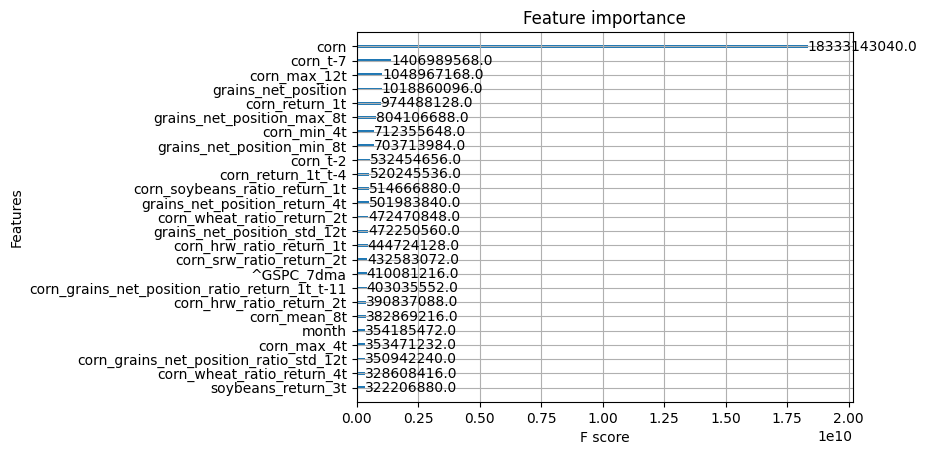

In [33]:
# plot feature importances
plot_importance(estimator, max_num_features=25, importance_type='gain')
plt.show()

## Feature selection

From the above chart we see that beyond the first variable, the feature importance score drops drastically. As such, the predictive contribution of subsequent variables quickly becomes marginal and we would do well to remove the least informative ones.

We first employ a simple (and somewhat arbitrary) heuristic by keeping the square root of the number of observations as the number of independent variables, which leaves us with 30 predictors. The earlier chart shows a top 25 and thus including 30 may in fact still leave us with uninformative features. However, in practice this is not much of an issue and we will account for this through a combination of L1 and L2 regularisation (i.e. elastic net) which shrinks the contribution of uninformative features and helps prevent overfitting.

In [34]:
# keep sqrt(observations) as # of features
k = int(len(X_train)**0.5)

# get feature importance scores
importance_scores = estimator.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
k_best_cols = feature_importance_df.iloc[:k]['Feature'].values

# select k best features
main_df = main_df[k_best_cols.tolist() + ['y']]
X_train = X_train[k_best_cols]

## Hyperparameter tuning

There are three main flavours of hyperparameter tuning, via exhaustive grid search, randomised grid search, and employing Bayesian optimisation algorithms. An exhaustive grid search has well known limitations in that it fails to consider the subspace between the predefined hyperparameters. A randomised search does better, but still does not consider convexity in the loss surface. Therefore, we opt to use the Optuna library, which employs Bayesian optimisation to iteratively consider a more optimal combination of hyperparameters.

Furthermore, we employ an expanding walk-forward time series validation approach using five folds, with each validation portion consisting of 52 weeks (i.e. one year). The first fold uses all data beginning from 2006 up to and including 2016 for training, then evaluates model performance on 2017. The next fold uses the same training data including 2017, then evaluates model performance on 2018. We roll forward in this fashion where our last evaluation fold is 2021.

We then return the average RMSE across these 5 folds for a given hyperparameter combination.

The hyperparameters being tuned are as follows:
- the number of trees within each ensemble
- the maximum individual tree depth
- the learning rate which determines how much each subsequent tree in the ensemble learns from the mistakes of the previous trees
- the L1 (alpha) and L2 (lambda) parameters which add penalty terms to the objective function in order to prevent overfitting

We wrap the above logic inside an Optuna study object which will seek to minimise the RMSE over 30 trials, which from experience is a sufficient number of iterations to find a near optimal hyperparameter combination.

In [35]:
%%time

def objective(trial):

    # xgboost regressor hyperparameters to explore
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'n_jobs': -1,
        'reg_alpha': trial.suggest_float('reg_alpha', 0., 3.),
        'reg_lambda': trial.suggest_float('reg_lambda', 0., 3.),
        'random_state': 42,
        'importance_type': 'gain',
    }

    # time series cross validation
    n_samples = len(train_df)
    tscv = TimeSeriesSplit(n_splits=5, test_size=52) # test folds of approx one year each

    # get rmse for each cross validation fold
    scores = cross_val_score(
        estimator=xgb.XGBRegressor(**params),
        X=X_train,
        y=y_train,
        scoring='neg_mean_squared_error',
        cv=tscv,
    )

    # return average rmse across folds
    return np.mean(scores)

# run bayesian hyperparameter optimisation with 30 trials
random_state = TPESampler(seed=1) # set random seed for reproducibility
study = optuna.create_study(direction='maximize', sampler=random_state)
study.optimize(objective, n_trials=30, gc_after_trial=True)

CPU times: user 8min 29s, sys: 1.86 s, total: 8min 31s
Wall time: 5min 3s


In [36]:
# display best hyperparameters
print('Best hyperparameters:', study.best_params)

Best hyperparameters: {'n_estimators': 310, 'max_depth': 2, 'learning_rate': 0.038825347340524535, 'reg_alpha': 0.5656501309577293, 'reg_lambda': 1.6475010552853013}


In [37]:
%%capture

# instantiate new model with best hyperparameters
estimator = xgb.XGBRegressor(**study.best_trial.params)

# refit model
estimator.fit(X_train, y_train)

# Walk forward model evaluation

The below function evaluates the performance of our final model on the test set. When no model is passed to the function, it will run a naive forecast, which simply takes the current observation $t$ as the best guess estimate for $t_{+1}$. Despite its simple approach, the naive model performs robustly for most financial time series given such series often adhere to a random walk where each subsequent step has no memory of past values.

We have chosen RMSE and MAPE as the performance metrics by which to compare our model versus the naive forecast. RMSE has the advantage of being directly interpretable as it is expressed in the same units as the variable being forecast. MAPE is unit-agnostic and expressed as a percentage, therefore allowing model comparison across different unit scales and domains.

Our function logic follows an application often used in real-world scenarios - such as, for example, with weather data - whereby we forecast one-step ahead and once the ground truth label becomes available as we move forward in time, we then incorporate this additional data point and retrain our model. We do this iteratively until we exhaust the entire test set.

Note, we do not retune our hyperparameters at each step as this would require excessive computational resources, but could choose to do so once we have a sufficient amount of new data available, for example once we have a calendar year's worth of additional data.

In [38]:
def expanding_walk_forward_evaluation(df, model='naive', train_size=0.8):
  """
  Performs an expanding walk-forward evaluation, where the model is trained
  on an increasing portion of the input data and evaluated on the subsequent time step.
  Note that the terms test and evaluation can be used interchangeably, as this function
  can be applied to either depending on the data provided.

  Parameters:
      - df (pd.DataFrame): DataFrame containing time series data as a supervised learning problem.
          Can have any number of X features, but y response vector must be 'y'.
      - model: Predictive model to be trained and evaluated. Must have .fit() and .predict() methods.
          If no model is specified, it will use a naive forecast taking the value of the most recent
          timestamp as the forecast value for t+1.
      - train_size (float): Fraction of data to use as the initial (unexpanded) training set.

  Returns:
      - y_trues (Series): Ground truth labels for the test set.
      - y_preds (Series): Predicted values for the test set.
      - residuals (Series): Residuals as ground truth minus predicted values.
      - mape (float): Mean Absolute Percentage Error between ground truth and predicted values.
  """

  # create a copy of dataframe to avoid override
  df = df.copy()

  # define X feature matrix and y response vector
  X = df.drop(columns='y')
  y = df['y']

  # index used to mark boundary between expanding training set and t+1 test set
  idx = int(len(df) * train_size)

  # ground truth labels and empty list to collect predicted values
  y_trues = y.iloc[idx:]
  y_preds = pd.Series(index=y_trues.index, dtype=np.float32)

  # naive forecast
  if model == 'naive':
    y_preds.loc[y_trues.index] = y.iloc[idx-1:-1].values

  # model specific forecast
  else:
    # perform walk forward evaluation
    for step in trange(len(df[idx:])):

      # training set for this fold
      X_train = X[:idx]
      y_train = y[:idx]

      # test set for this fold
      X_test = X.iloc[[idx]]

      # fit model using training set and use trained model to predict t+1
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)[0]
      y_preds[y_trues.index[step]] = y_pred

      # increment train-test boundary index
      idx += 1

  # compute residual and performance metrics
  residuals = y_trues - y_preds
  rmse = mean_squared_error(y_trues, y_preds, squared=False)
  mae = mean_absolute_error(y_trues, y_preds)
  mape = mean_absolute_percentage_error(y_trues, y_preds)

  return y_trues, y_preds, residuals, mape, rmse

## Naive forecast performance on test set

In order to establish a benchmark level of performance on the test set, we apply the naive forecast approach.

This yields an RMSE of 34,619 and MAPE of 56.2%.

In [39]:
naive_forecast = expanding_walk_forward_evaluation(
    df = main_df,
    train_size = len(train_df) / len(main_df),
)

In [40]:
print(f"""
  BENCHMARK METRICS
  Using a naive forecast
  - - -
  RMSE: {naive_forecast[-1]:.3f}
  MAPE: {naive_forecast[-2]:.3f}
  """
  )


  BENCHMARK METRICS
  Using a naive forecast
  - - -
  RMSE: 34619.003
  MAPE: 0.562
  


## Tuned model performance on test set

Running our tuned model on the holdout test set, the results once again confirm that it is indeed challenging to outperform a simple naive forecast.

Although our model achieved a slightly worse RMSE of 35,102, it did however yield a much better MAPE of 47.2%, which is an improvement of 9% over the benchmark.

In [41]:
xgb_forecast = expanding_walk_forward_evaluation(
    df = main_df,
    model = estimator,
    train_size = len(train_df) / len(main_df),
)

100%|██████████| 106/106 [00:54<00:00,  1.94it/s]


In [42]:
print(f"""
  PERFORMANCE METRICS
  Using XGBoost Regressor
  - - -
  RMSE: {xgb_forecast[-1]:.3f}
  MAPE: {xgb_forecast[-2]:.3f}
  """
  )


  PERFORMANCE METRICS
  Using XGBoost Regressor
  - - -
  RMSE: 35102.464
  MAPE: 0.472
  


## Residuals analysis

An important, yet often neglected, part of model evaluation is analysing the residuals. The residuals are the individual differences between the observed (true) values and predicted values. The aim is to inspect whether our model has managed to capture all signal from the data. In order to establish whether this is the case, we would commonly look to satisfy these four criteria:
- residuals have a mean of zero
- residuals have a constant variance (i.e. homoskedastic and time invariant)
- residuals follow a Gaussian distribution
- residuals are not autocorrelated

In [43]:
y_trues, y_preds, residuals, mape, rmse = xgb_forecast

First, we visually inspect whether our residuals appear to be a white noise series with a mean of zero and constant variance. This indeed appears to be the case, although perhaps there is minimal downward drift over time.

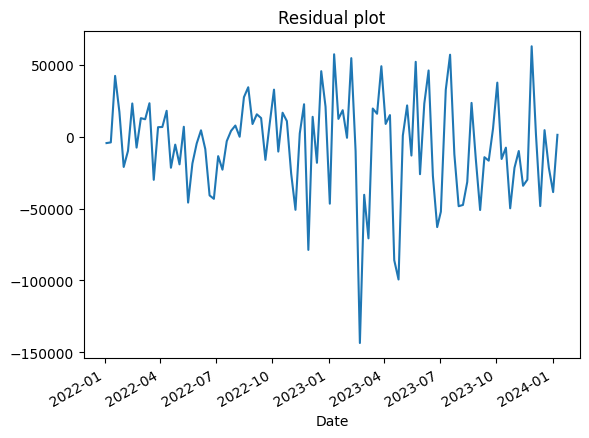

In [44]:
residuals.plot()
plt.title(f'Residual plot')
plt.show()

Constant mean and variance imply that our residuals should be stationary and we can check this by applying an Augmented Dicky-Fuller test, which confirms this to be true.

In [45]:
# perform adf test
result = sm.tsa.adfuller(residuals)

# extract and print the test statistic and p-value
adf_statistic = result[0]
p_value = result[1]

print(f'ADF Test Statistic:\t{adf_statistic:.6f}')
print(f'p-value:\t\t{p_value:.6f}')
print('- - -')

# interpret the results
if p_value <= 0.05:
    print('Reject the null hypothesis (H0) \nThe residuals time series is stationary')
else:
    print('Fail to reject the null hypothesis (H0) \nThe residuals time series is non-stationary')

ADF Test Statistic:	-8.636859
p-value:		0.000000
- - -
Reject the null hypothesis (H0) 
The residuals time series is stationary


Next, we perform another visual check to see whether our residuals were drawn from a normal distribution. Although the shape of the curve does resemble the familiar bell-shape, its mean is not centred on zero. Additionally, the distribution seems to show a slightly negative skew and positive kurtosis (leptokurtic).

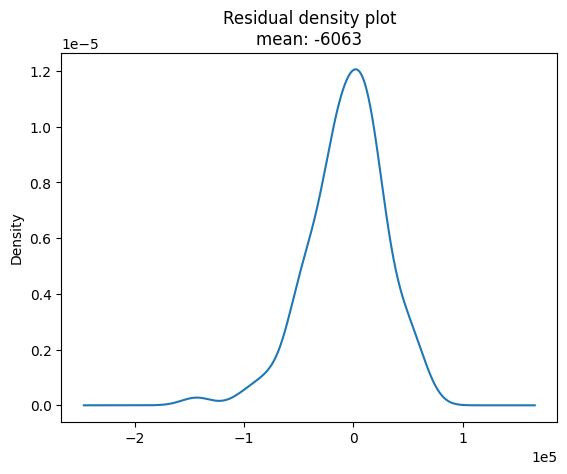

In [46]:
residuals.plot(kind='density')
plt.title(f'Residual density plot\nmean: {int(residuals.mean())}')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

A more statistically robust approach to check whether our residuals meet the assumption of normality is through either a Jarque-Bera test or Shapiro-Wilk test. The latter is known to perform better for smaller sample sizes, which is relevant to our case. We run both tests hereunder and - in line with our visual inspection - confirm that the residuals are not normally distributed, which suggests that our model has not extracted all signal from the data.

In [47]:
# perform jarque-bera test of normality on residuals
statistic, p_value = jarque_bera(residuals)

print(f'Jarque-Bera Test Statistic:\t{statistic:.6f}')
print(f'p-value:\t\t\t{p_value:.6f}')
print('- - -')

# interpret the results
if p_value <= 0.05:
    print('Reject the null hypothesis (H0) \nThe residuals time series was not drawn from a normal distribution')
else:
    print('Fail to reject the null hypothesis (H0) \nThe residuals time series was drawn from a normal distribution')

Jarque-Bera Test Statistic:	21.596423
p-value:			0.000020
- - -
Reject the null hypothesis (H0) 
The residuals time series was not drawn from a normal distribution


In [48]:
# perform shapiro-wilk test of normality on residuals
statistic, p_value = shapiro(residuals)

print(f'Shapiro-Wilk Test Statistic:\t{statistic:.6f}')
print(f'p-value:\t\t\t{p_value:.6f}')
print('- - -')

# interpret the results
if p_value <= 0.05:
    print('Reject the null hypothesis (H0) \nThe residuals time series was not drawn from a normal distribution')
else:
    print('Fail to reject the null hypothesis (H0) \nThe residuals time series was drawn from a normal distribution')

Shapiro-Wilk Test Statistic:	0.965261
p-value:			0.007077
- - -
Reject the null hypothesis (H0) 
The residuals time series was not drawn from a normal distribution


Finally, we check whether our residuals still contain any signal in the form of autocorrelation. The first spike outside the 95% confidence interval (light blue band) is at $t_{-0}$ and is the correlation of a residual with itself, which is always 100%. Beyond that, we observe potentially statistically significant autocorrelation at $t_{-13}$. However, it is worth noting that we should expect to see one false positive for every 20 lags given the default $\alpha$ threshold of 0.05. Additionally, the value at $t_{-13}$ is only marginally beyond the confidence band and therefore not likely to be meaningful.

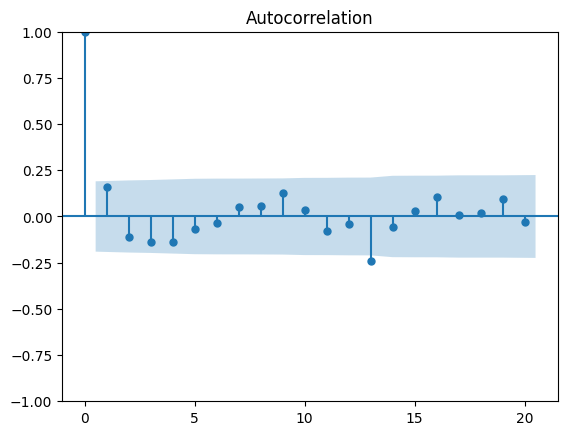

In [49]:
sm.graphics.tsa.plot_acf(residuals, lags=20)
plt.show()

# Results

- Our gradient boosted decision tree model managed to outperform the benchmark naive forecast by 9% when assessed for its MAPE. It performed close to on par when assessed for its RMSE.

- By far the most informative feature when predicting next week's managed money net position is the current week's net position. This also explains why the naive forecast performs strongly for this particular time series problem.

- Our error analysis showed that the residuals are not normally distributed and therefore our model has likely not been able to capture all signal from the data.

# Next steps

- In order to improve our model performance, the first step is always to see whether we can get more data. This is in fact possible by performing the same feature engineering for other agricultural commodities and then concatenating the datasets. In other words, if we perform this same analysis on soybeans, for example, we can then use that dataset and vertically append it to our existing corn-focused dataset. We would need to account for any commodity specific variables, such as some of the ratios, and removing these would allow us to align the data.

- The next step in improving model performance would be further feature engineering and/or incorporating additional variables that may be informative of managed money behaviour, such as interest rates, currency exchange rates, crude oil prices, weather data for key agricultural regions, etc.

- Outperforming a benchmark is an appropriate theoretical first step, however a potential next step would be to integrate these managed money net position forecasts into a trading strategy and assess whether doing so generates additional profitability.

# END

In [50]:
# dependencies
%load_ext watermark
%watermark --python --iversions

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

optuna     : 3.5.0
seaborn    : 0.13.1
pandas     : 1.5.3
statsmodels: 0.14.1
numpy      : 1.23.5
xgboost    : 2.0.3
yfinance   : 0.2.36
cot_reports: 0.1.3
matplotlib : 3.7.1



**Author: Vladimir Zinkovski**

Send an email: *vladimir.zinkovski@gmail.com*

Or connect with me on: [LinkedIn](https://www.linkedin.com/in/vladimir-zinkovski/)